wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tseesuren (tseesuren-novelsoft) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cpu
user num: 5949
item num: 2810
Loaded dataset with 5949 users and 2810 items.
Training enhanced diffusion model with user similarity...
Computing user similarity matrix...
Computing cosine similarity by top-k...
Cosine similarity computed.
Filtering top-k values...


Preparing cosine similarity matrix | Top-K: 1000: ❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯❯ 100% | 00:02


Finding top-10 similar users for each user...
User similarity initialization complete!


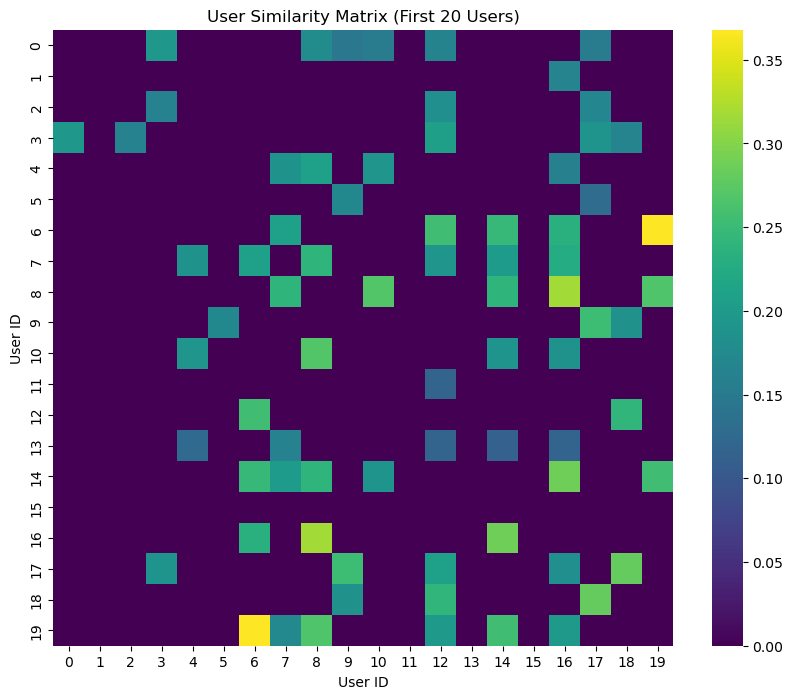

Visualization of user similarity matrix saved to user_similarity_matrix.png
Models initialized successfully.
Number of all parameters: 5633920
Start training...


Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

End. Best Epoch 045
[Valid]: Precision: 0.072-0.0663-0.056-0.0471 Recall: 0.0626-0.1106-0.2167-0.3401 NDCG: 0.0863-0.0992-0.1347-0.1784 MRR: 0.1714-0.1826-0.1892-0.1908
[Test]: Precision: 0.0582-0.0518-0.0417-0.0329 Recall: 0.0929-0.1582-0.2972-0.4347 NDCG: 0.0853-0.1067-0.1527-0.195 MRR: 0.1471-0.1587-0.166-0.1676


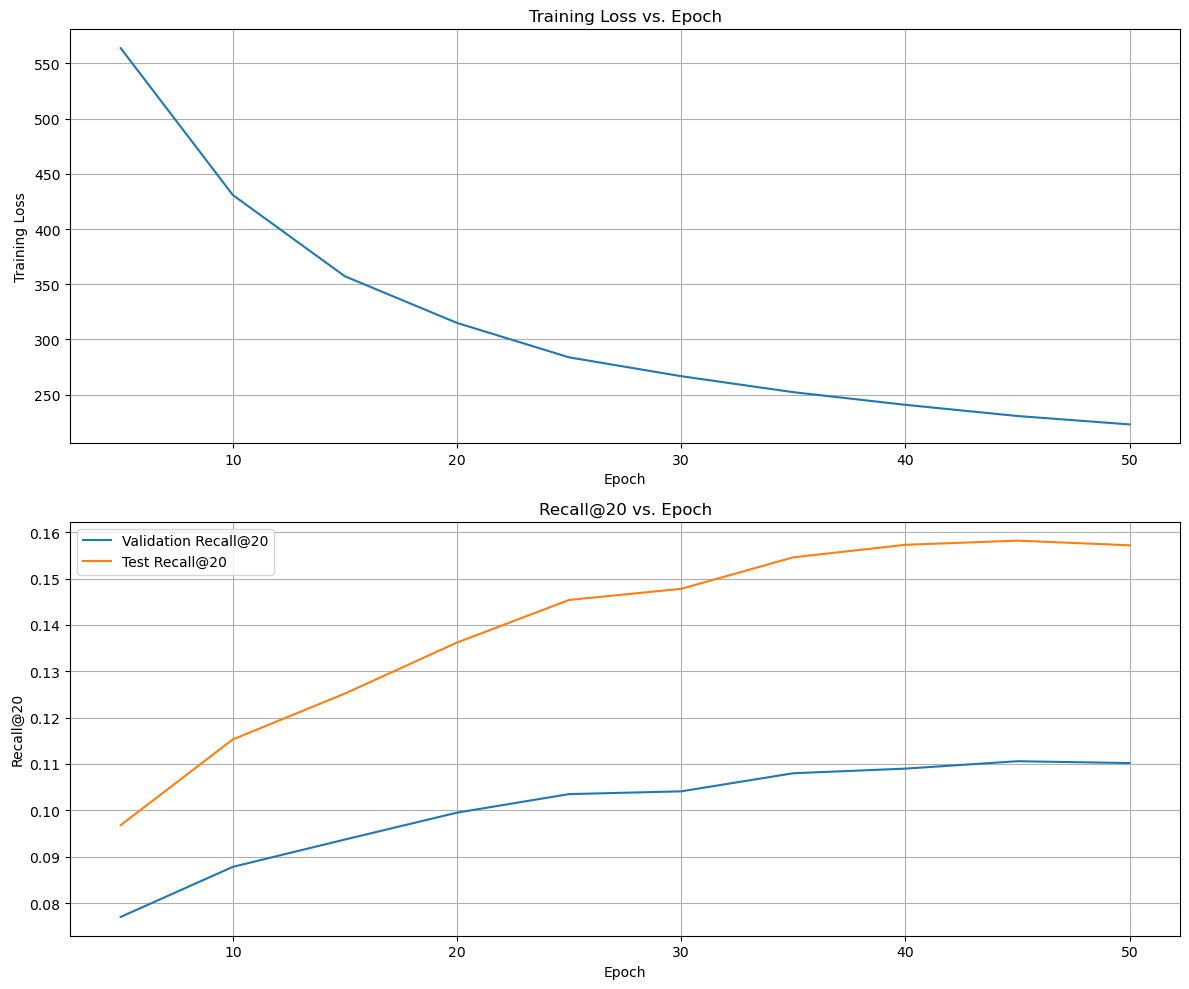

Training completed!


In [ ]:
import os
import time
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sys

# Set command line arguments for Jupyter notebook environment
sys.argv = ['diffusion_training.py', '--dataset', 'ml-1m', '--data_path', 'data/', 
           '--batch_size', '400', '--epochs', '50', '--use_similarity', 'True',
           '--top_k', '10', '--gamma', '0.0']

# Import custom modules
from models.enhanced_gaussian_diffusion import EnhancedGaussianDiffusion, ModelMeanType
from models.DNN import DNN
from enhanced_sampling import enhance_p_sample
from evaluation_update import enhanced_evaluate
import evaluate_utils
import data_utils

# Set random seeds for reproducibility
def set_seed(seed=42):
    random_seed = seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    np.random.seed(random_seed)
    import random
    random.seed(random_seed)
    torch.backends.cudnn.deterministic = True

def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default='ml-1m', help='choose the dataset')
    parser.add_argument('--data_path', type=str, default='data/', help='load data path')
    parser.add_argument('--lr', type=float, default=0.0001, help='learning rate')
    parser.add_argument('--weight_decay', type=float, default=0.0)
    parser.add_argument('--batch_size', type=int, default=400)
    parser.add_argument('--epochs', type=int, default=100, help='upper epoch limit')
    parser.add_argument('--topN', type=str, default='[10, 20, 50, 100]')
    parser.add_argument('--cuda', action='store_true', help='use CUDA')
    parser.add_argument('--gpu', type=str, default='0', help='gpu card ID')
    parser.add_argument('--save_path', type=str, default='./saved_models/', help='save model path')
    
    # Params for the model
    parser.add_argument('--time_type', type=str, default='cat', help='cat or add')
    parser.add_argument('--dims', type=str, default='[1000]', help='the dims for the DNN')
    parser.add_argument('--norm', type=bool, default=False, help='Normalize the input or not')
    parser.add_argument('--emb_size', type=int, default=10, help='timestep embedding size')

    # Params for diffusion
    parser.add_argument('--mean_type', type=str, default='x0', help='MeanType for diffusion: x0, eps')
    parser.add_argument('--steps', type=int, default=100, help='diffusion steps')
    parser.add_argument('--noise_schedule', type=str, default='linear-var', help='the schedule for noise generating')
    parser.add_argument('--noise_scale', type=float, default=0.1, help='noise scale for noise generating')
    parser.add_argument('--noise_min', type=float, default=0.0001, help='noise lower bound for noise generating')
    parser.add_argument('--noise_max', type=float, default=0.02, help='noise upper bound for noise generating')
    parser.add_argument('--sampling_noise', type=bool, default=False, help='sampling with noise or not')
    parser.add_argument('--sampling_steps', type=int, default=0, help='steps of the forward process during inference')
    parser.add_argument('--reweight', type=bool, default=True, help='assign different weight to different timestep or not')

    # Params for user similarity
    parser.add_argument('--use_similarity', type=bool, default=False, help='use user similarity aggregation')
    parser.add_argument('--top_k', type=int, default=10, help='number of similar users for aggregation')
    parser.add_argument('--gamma', type=float, default=0.7, help='weight for user vector vs similar users')
    parser.add_argument('--temperature', type=float, default=0.5, help='temperature for weighted averaging')
    
    # Execution modes
    parser.add_argument('--ablation', action='store_true', help='run ablation studies on gamma and temperature')
    
    return parser.parse_args()

def visualize_similarity_matrix(similarity_matrix, n_users=20):
    """Visualize a subset of the user similarity matrix."""
    # Select a subset of users for visualization
    subset_matrix = similarity_matrix[:n_users, :n_users].cpu().numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(subset_matrix, annot=False, cmap='viridis')
    plt.title(f'User Similarity Matrix (First {n_users} Users)')
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.savefig('user_similarity_matrix.png')
    plt.show()
    
    print(f"Visualization of user similarity matrix saved to user_similarity_matrix.png")

def train_model(args, train_data, valid_y_data, test_y_data, n_user, n_item, run, device):
    # Create data loaders
    train_dataset = data_utils.DataDiffusion(torch.FloatTensor(train_data.A))
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, 
                             shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)
    test_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)

    mask_tv = train_data + valid_y_data

    # Build Enhanced Gaussian Diffusion
    if args.mean_type == 'x0':
        mean_type = ModelMeanType.START_X
    elif args.mean_type == 'eps':
        mean_type = ModelMeanType.EPSILON
    else:
        raise ValueError("Unimplemented mean type %s" % args.mean_type)

    diffusion = EnhancedGaussianDiffusion(
        mean_type=mean_type, 
        noise_schedule=args.noise_schedule,
        noise_scale=args.noise_scale, 
        noise_min=args.noise_min, 
        noise_max=args.noise_max, 
        steps=args.steps, 
        device=device,
        top_k=args.top_k,
        gamma=args.gamma,
        use_similarity=args.use_similarity,
        temperature=args.temperature
    ).to(device)
    
    # Set sampling parameters
    diffusion.sampling_steps = args.sampling_steps
    diffusion.sampling_noise = args.sampling_noise

    # Initialize User Similarity Matrix
    if args.use_similarity:
        diffusion.initialize_similarity_matrix(train_data)
        # Visualize the similarity matrix
        visualize_similarity_matrix(diffusion.similarity_matrix, n_users=20)

    # Build MLP
    out_dims = eval(args.dims) + [n_item]
    in_dims = out_dims[::-1]
    model = DNN(in_dims, out_dims, args.emb_size, time_type="cat", norm=args.norm).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    print("Models initialized successfully.")

    param_num = 0
    mlp_num = sum([param.nelement() for param in model.parameters()])
    diff_num = sum([param.nelement() for param in diffusion.parameters()])  # Should be 0
    param_num = mlp_num + diff_num
    print("Number of all parameters:", param_num)

    best_recall, best_epoch = -100, 0
    best_results = None
    best_test_results = None

    print("Start training...")
    
    # Training metrics tracking
    all_epochs = []
    train_losses = []
    valid_recalls = []
    test_recalls = []
    
    # Initialize tqdm for epoch-level progress bar
    pbar = tqdm(range(1, args.epochs + 1), 
                bar_format='{l_bar}{bar}{r_bar}',
                desc="Training progress")

    for epoch in pbar:
        if epoch - best_epoch >= 200:
            pbar.set_description(f"Early stopping at epoch {epoch}")
            break
        
        model.train()
        start_time = time.time()
        
        batch_count = 0
        total_loss = 0.0
        
        # Training loop
        for batch_idx, batch in enumerate(train_loader):
            # Get batch indices for enhanced sampling later
            batch_start = batch_idx * args.batch_size
            batch_end = min(batch_start + len(batch), n_user)
            batch_indices = torch.arange(batch_start, batch_end, device=device)
            
            batch = batch.to(device)
            batch_count += 1
            optimizer.zero_grad()
            losses = diffusion.training_losses(model, batch, args.reweight)
            loss = losses["loss"].mean()
            total_loss += loss
            loss.backward()
            optimizer.step()

        # Update the progress bar description with the final loss
        pbar.set_description(f"Epoch {epoch:03d} | Loss {total_loss:.4f}")

        # Evaluation every 5 epochs
        if epoch % 5 == 0:
            # Use the enhanced evaluation function that includes batch indices
            valid_results = enhanced_evaluate(
                diffusion, model, test_loader, valid_y_data, train_data, eval(args.topN)
            )
            test_results = enhanced_evaluate(
                diffusion, model, test_loader, test_y_data, mask_tv, eval(args.topN)
            )
            
            # Format evaluation results
            valid_recall = valid_results[1][1]  # recall@20
            test_recall = test_results[1][1]
            valid_ndcg = valid_results[2][1]  # NDCG@20
            test_ndcg = test_results[2][1]
            
            run.log({
                "Recall/Valid": valid_recall, 
                "Recall/Test": test_recall,
                "NDCG/Valid": valid_ndcg,
                "NDCG/Test": test_ndcg,
                "Loss/Total": total_loss
            })
            
            # Store metrics for plotting
            all_epochs.append(epoch)
            train_losses.append(total_loss.item())
            valid_recalls.append(valid_recall)
            test_recalls.append(test_recall)
            
            # Update the progress bar with the metrics
            pbar.set_postfix(valid_recall=valid_recall, test_recall=test_recall,
                            valid_ndcg=valid_ndcg, test_ndcg=test_ndcg)
            
            # Check for the best results and save model if improved
            if valid_recall > best_recall:  # recall@20 as selection
                best_recall, best_epoch = valid_recall, epoch
                best_results = valid_results
                best_test_results = test_results
                
                # Save the model with the best performance
                if not os.path.exists(args.save_path):
                    os.makedirs(args.save_path)
                model_save_path = f'{args.save_path}{args.dataset}_similarity_best_model_epoch_{epoch}.pth'
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_recall': best_recall,
                    'config': {
                        'top_k': args.top_k,
                        'gamma': args.gamma,
                        'use_similarity': args.use_similarity,
                        'temperature': args.temperature
                    }
                }, model_save_path)
                
                pbar.set_postfix(best_valid_recall=f"{best_recall:.4f} (epoch {best_epoch})")

        # Log epoch completion
        elapsed = time.time() - start_time
        pbar.set_description(f"Epoch {epoch:03d} completed | Loss {total_loss:.4f} | Time {time.strftime('%H:%M:%S', time.gmtime(elapsed))}")

    # Final results
    print('='*54)
    print(f"End. Best Epoch {best_epoch:03d}")
    evaluate_utils.print_results(None, best_results, best_test_results)
    
    # Plot training progress
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(all_epochs, train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epoch')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(all_epochs, valid_recalls, label='Validation Recall@20')
    plt.plot(all_epochs, test_recalls, label='Test Recall@20')
    plt.xlabel('Epoch')
    plt.ylabel('Recall@20')
    plt.title('Recall@20 vs. Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()
    
    return diffusion, model

def run_ablation_study(args, train_data, valid_y_data, test_y_data, n_user, n_item, device):
    """Run ablation studies on gamma and temperature parameters."""
    gamma_values = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
    temperature_values = [0.1, 0.5, 1.0, 2.0]
    
    # Create data loaders
    train_dataset = data_utils.DataDiffusion(torch.FloatTensor(train_data.A))
    test_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    mask_tv = train_data + valid_y_data
    
    # Setup for results collection
    gamma_results = {'recall': [], 'ndcg': []}
    temp_results = {'recall': [], 'ndcg': []}
    
    # Setup model architecture
    out_dims = eval(args.dims) + [n_item]
    in_dims = out_dims[::-1]
    
    # Study gamma parameter
    print("\n===== GAMMA ABLATION STUDY =====")
    fixed_temp = 0.5  # Fix temperature
    for gamma in gamma_values:
        print(f"\nTesting with gamma = {gamma}, temperature = {fixed_temp}")
        
        # Create model
        model = DNN(in_dims, out_dims, args.emb_size, time_type="cat", norm=args.norm).to(device)
        
        # Create diffusion with current gamma
        if args.mean_type == 'x0':
            mean_type = ModelMeanType.START_X
        else:
            mean_type = ModelMeanType.EPSILON
            
        diffusion = EnhancedGaussianDiffusion(
            mean_type=mean_type, 
            noise_schedule=args.noise_schedule,
            noise_scale=args.noise_scale, 
            noise_min=args.noise_min, 
            noise_max=args.noise_max, 
            steps=args.steps, 
            device=device,
            top_k=args.top_k,
            gamma=gamma,
            use_similarity=args.use_similarity,
            temperature=fixed_temp
        ).to(device)
        
        diffusion.sampling_steps = args.sampling_steps
        diffusion.sampling_noise = args.sampling_noise
        
        # Initialize similarity matrix
        diffusion.initialize_similarity_matrix(train_data)
        
        # Load the best model if available
        import glob
        model_files = glob.glob(f'{args.save_path}{args.dataset}_similarity_best_model_*.pth')
        if model_files:
            latest_model = max(model_files, key=os.path.getctime)
            print(f"Loading model: {latest_model}")
            checkpoint = torch.load(latest_model, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
        
        # Evaluate
        test_results = enhanced_evaluate(
            diffusion, model, test_loader, test_y_data, mask_tv, eval(args.topN)
        )
        
        # Store results
        gamma_results['recall'].append(test_results[1][1])  # recall@20
        gamma_results['ndcg'].append(test_results[2][1])    # ndcg@20
        
        print(f"Results: Recall@20 = {test_results[1][1]}, NDCG@20 = {test_results[2][1]}")
    
    # Study temperature parameter
    print("\n===== TEMPERATURE ABLATION STUDY =====")
    fixed_gamma = 0.7  # Fix gamma
    for temp in temperature_values:
        print(f"\nTesting with gamma = {fixed_gamma}, temperature = {temp}")
        
        # Create model
        model = DNN(in_dims, out_dims, args.emb_size, time_type="cat", norm=args.norm).to(device)
        
        # Create diffusion with current temperature
        if args.mean_type == 'x0':
            mean_type = ModelMeanType.START_X
        else:
            mean_type = ModelMeanType.EPSILON
            
        diffusion = EnhancedGaussianDiffusion(
            mean_type=mean_type, 
            noise_schedule=args.noise_schedule,
            noise_scale=args.noise_scale, 
            noise_min=args.noise_min, 
            noise_max=args.noise_max, 
            steps=args.steps, 
            device=device,
            top_k=args.top_k,
            gamma=fixed_gamma,
            use_similarity=args.use_similarity,
            temperature=temp
        ).to(device)
        
        diffusion.sampling_steps = args.sampling_steps
        diffusion.sampling_noise = args.sampling_noise
        
        # Initialize similarity matrix
        diffusion.initialize_similarity_matrix(train_data)
        
        # Load the best model if available
        import glob
        model_files = glob.glob(f'{args.save_path}{args.dataset}_similarity_best_model_*.pth')
        if model_files:
            latest_model = max(model_files, key=os.path.getctime)
            print(f"Loading model: {latest_model}")
            checkpoint = torch.load(latest_model, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
        
        # Evaluate
        test_results = enhanced_evaluate(
            diffusion, model, test_loader, test_y_data, mask_tv, eval(args.topN)
        )
        
        # Store results
        temp_results['recall'].append(test_results[1][1])  # recall@20
        temp_results['ndcg'].append(test_results[2][1])    # ndcg@20
        
        print(f"Results: Recall@20 = {test_results[1][1]}, NDCG@20 = {test_results[2][1]}")
    
    # Plot gamma results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(gamma_values, gamma_results['recall'], 'o-', linewidth=2)
    plt.xlabel('Gamma')
    plt.ylabel('Recall@20')
    plt.title('Effect of Gamma on Recall@20')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(gamma_values, gamma_results['ndcg'], 'o-', linewidth=2)
    plt.xlabel('Gamma')
    plt.ylabel('NDCG@20')
    plt.title('Effect of Gamma on NDCG@20')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('gamma_ablation_study.png')
    plt.show()
    
    # Plot temperature results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(temperature_values, temp_results['recall'], 'o-', linewidth=2)
    plt.xlabel('Temperature')
    plt.ylabel('Recall@20')
    plt.title('Effect of Temperature on Recall@20')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(temperature_values, temp_results['ndcg'], 'o-', linewidth=2)
    plt.xlabel('Temperature')
    plt.ylabel('NDCG@20')
    plt.title('Effect of Temperature on NDCG@20')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('temperature_ablation_study.png')
    plt.show()
    
    print("Ablation study results saved to gamma_ablation_study.png and temperature_ablation_study.png")

def main():
    # Parse arguments
    args = parse_args()
    
    import wandb

    # Start a new wandb run to track this script.
    run = wandb.init(
        # Set the wandb entity where your project will be logged (generally your team name).
        entity="tseesuren-novelsoft",
        # Set the wandb project where this run will be logged.
        project="diffRec",
        # Track hyperparameters and run metadata.
        config={
            "learning_rate": args.lr,
            "architecture": "DySimGCF",
            "dataset": "Ml-100k",
            "epochs": args.epochs,
            "batch_size": args.batch_size,
        },
    )
    
    # Set defaults for missing arguments
    if not hasattr(args, 'ablation'):
        args.ablation = False
    
    # Set random seed for reproducibility
    set_seed(42)
    
    # Set up device
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    device = torch.device("cuda:0" if args.cuda else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    train_path = args.data_path + args.dataset + '/train_list.npy'
    valid_path = args.data_path + args.dataset + '/valid_list.npy'
    test_path = args.data_path + args.dataset + '/test_list.npy'
    
    try:
        train_data, valid_y_data, test_y_data, n_user, n_item = data_utils.data_load(train_path, valid_path, test_path)
        print(f"Loaded dataset with {n_user} users and {n_item} items.")
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please make sure the dataset exists in the specified path.")
        import sys
        sys.exit(1)
    
    # Check if we should run ablation study
    if args.ablation:
        print("Running ablation studies...")
        run_ablation_study(args, train_data, valid_y_data, test_y_data, n_user, n_item, device)
    else:
        # Train the model
        print("Training enhanced diffusion model with user similarity...")
        diffusion, model = train_model(args, train_data, valid_y_data, test_y_data, n_user, n_item, run, device)
        print("Training completed!")

if __name__ == "__main__":
    main()